Installing Tensorflow & Keras

In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

Initial Data Inspection

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
data = pd.read_csv("/content/MicrosoftStock.csv")

In [ ]:
print(data.head())

    index        date   open   high    low  close    volume  Name
0  390198  2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199  2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200  2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201  2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202  2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB
None


In [ ]:
print(data.describe())

               index         open  ...        close        volume
count    1259.000000  1259.000000  ...  1259.000000  1.259000e+03
mean   390827.000000    51.026394  ...    51.063081  3.386946e+07
std       363.586303    14.859387  ...    14.852117  1.958979e+07
min    390198.000000    27.350000  ...    27.370000  7.425603e+06
25%    390512.500000    40.305000  ...    40.310000  2.254879e+07
50%    390827.000000    47.440000  ...    47.520000  2.938758e+07
75%    391141.500000    59.955000  ...    59.730000  3.842024e+07
max    391456.000000    95.140000  ...    95.010000  2.483542e+08

[8 rows x 6 columns]


Initial Data Visualization

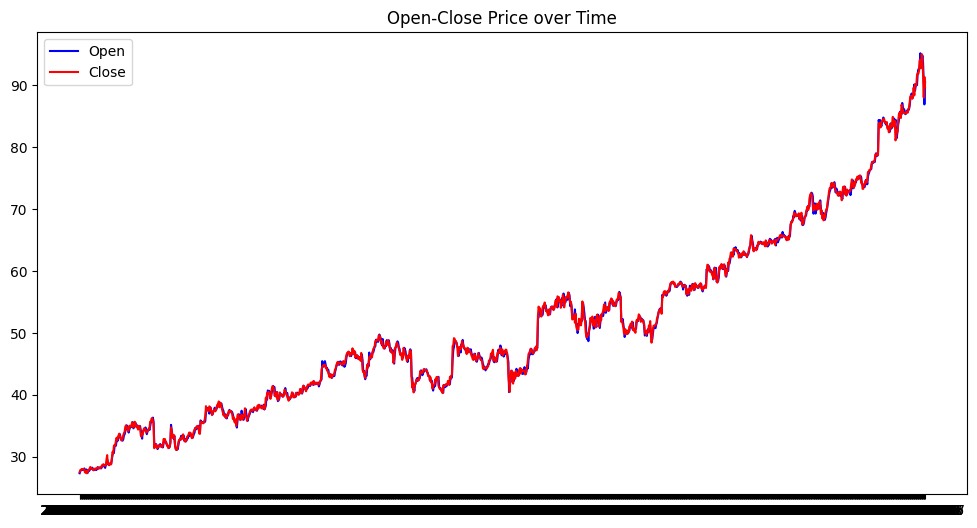

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['open'], label="Open",color="blue")
plt.plot(data['date'], data['close'], label="Close",color="red")
plt.title("Open-Close Price over Time")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Stock Volume over Time')

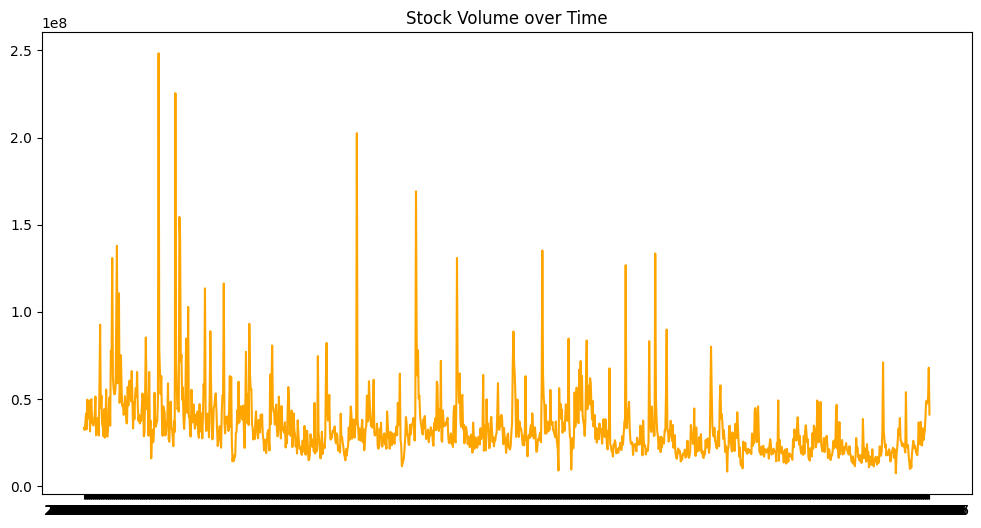

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data['date'],data['volume'],label="Volume",color="orange")
plt.title("Stock Volume over Time")

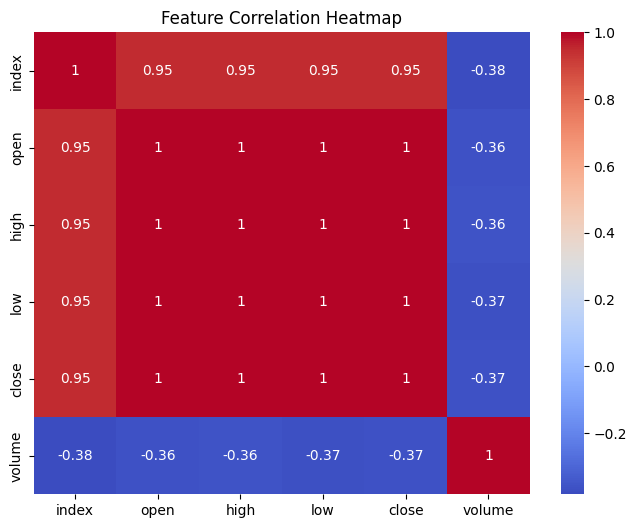

In [ ]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

Text(0.5, 1.0, 'Price over time')

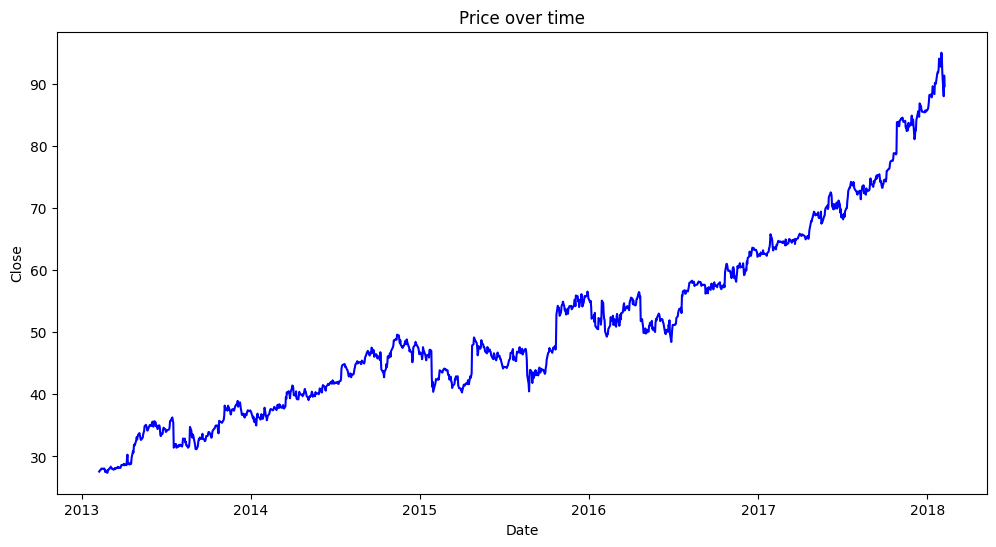

In [ ]:
data['date'] = pd.to_datetime(data['date'])
prediction = data.loc[
    (data['date'] > datetime(2013,1,1)) &
    (data['date'] < datetime(2018,1,1))]
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['close'],color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")

The LSTM Model

In [25]:
stock_close = data.filter(["close"])
dataset = stock_close.values
training_data_len = int(np.ceil(len(dataset) * 0.95))

In [26]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [27]:
training_data = scaled_data[:training_data_len]

In [28]:
X_train, y_train = [], []

In [29]:
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i,0])

In [31]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [32]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [34]:
model = keras.models.Sequential()

In [35]:
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
model.add(keras.layers.LSTM(64, return_sequences=False))

In [37]:
model.add(keras.layers.Dense(128, activation="relu"))

In [39]:
model.add(keras.layers.Dropout(0.5))

In [38]:
model.add(keras.layers.Dense(1))

In [40]:
model.summary()
model.compile(optimizer="adam",
              loss="mae",
              metrics=[keras.metrics.RootMeanSquaredError()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
training = model.fit(X_train, y_train, epochs=20, batch_size=32)
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.5038 - root_mean_squared_error: 0.6781
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.3883 - root_mean_squared_error: 0.5823
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.3729 - root_mean_squared_error: 0.5846
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.3728 - root_mean_squared_error: 0.5696
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.3659 - root_mean_squared_error: 0.5766
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3574 - root_mean_squared_error: 0.5596
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.4118 - root_mean_squared_error: 0.6155
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.3392 - root_mean_squared_error: 0.5434
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.3490 - root_mean_squared_error: 0.5638
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.3707 - root_mean_squared_error: 0.580

Plot the Predictions

In [42]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 843ms/step


In [43]:
train = data[:training_data_len]
test =  data[training_data_len:]

In [44]:
test = test.copy()

In [45]:
test['Predictions'] = predictions

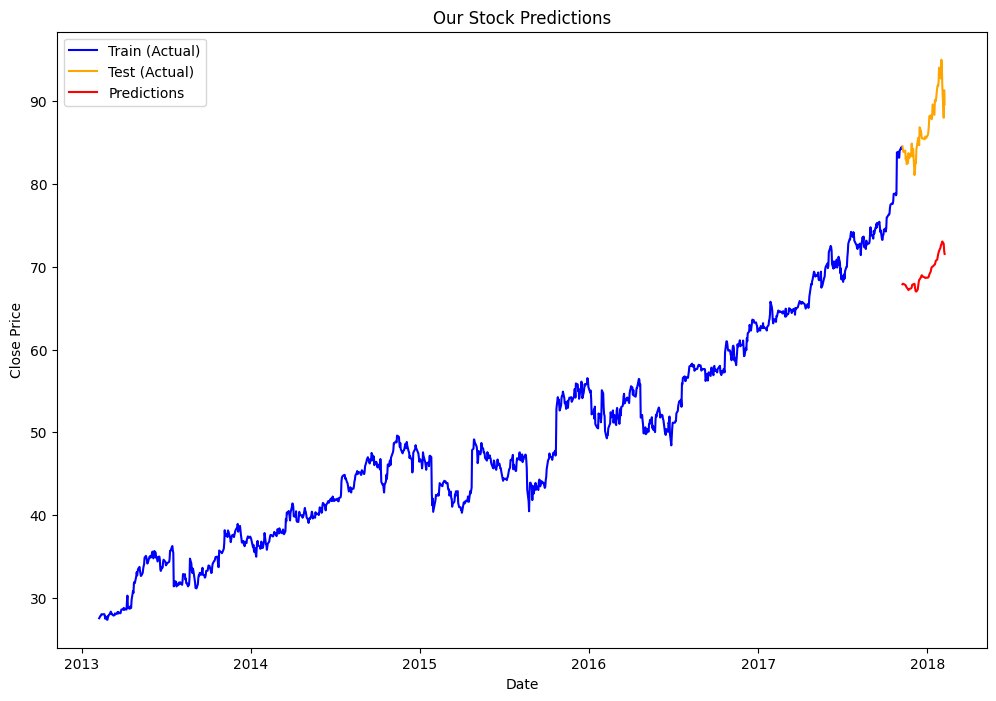

In [46]:
plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()